In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [12]:
# We shall improve the results of the CNN for CIFAR-10 dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [13]:
K = len(set(y_train))

In [15]:
# Build the model (taking inspiration from the VGG network which does multiple Conv's before pooling)
# Using max pooling rather than strided convolutions works better
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) # padding same means the image wont shrink after the convolution
# normalize each batch of training examples, so that network becomes impervious to noise and doesnt overfit
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3104 - accuracy: 0.5607 - val_loss: 0.9203 - val_accuracy: 0.6879
Epoch 2/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8436 - accuracy: 0.7073 - val_loss: 0.8294 - val_accuracy: 0.7184
Epoch 3/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6982 - accuracy: 0.7604 - val_loss: 0.7411 - val_accuracy: 0.7460
Epoch 4/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5912 - accuracy: 0.7970 - val_loss: 0.7321 - val_accuracy: 0.7541
Epoch 5/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4947 - accuracy: 0.8306 - val_loss: 0.6463 - val_accuracy: 0.7839
Epoch 6/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4187 - accuracy: 0.8555 - val_loss: 0.6616 - val_accuracy: 0.7857
Epoch 7/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3540 - accuracy: 0.8771 - val_loss: 0.6595 - val_ac

In [20]:
# Fit with data augmentation
# Note: if you run this after calling the previous fit(), it will continue training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=.1, height_shift_range=.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit_generator(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)
# Takes time to run this, but it ends up resulting in lower training accuracy but higher validation accuracy
# This is an improvement, less overfitting. So data augmentation helps

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


 1563/50000 [..............................] - ETA: 15:09 - loss: 0.5533 - accuracy: 0.8245WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2500000 batches). You may need to use the repeat() function when building your dataset.


50000/50000 [==============================] - 31s 617us/step - loss: 0.5533 - accuracy: 0.8245 - val_loss: 0.5033 - val_accuracy: 0.8405


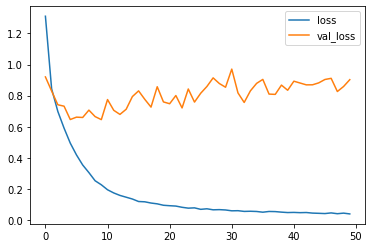

In [18]:
# Plot loss and accuracy
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

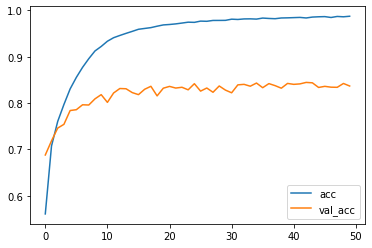

In [19]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  '''
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting "normalize=True
  '''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=l)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

In [ ]:
# Show misclassified examples (now the misclassified ones make sense. They look very similar or look like blobs)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [ ]:
# Now that the model is so large, its useful to summarize it
model.summary()